In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import EvaluationModule

import xgboost as xgb
import sklearn
from sklearn.model_selection import ShuffleSplit,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression

(CVXPY) Jul 18 11:22:40 AM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 18 11:22:40 AM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 18 11:22:40 AM: Encountered unexpected exception importing solver GLPK_MI:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/e

# Data Module

In [2]:
dataset = CoronnaCERTAINDataset(
    library_root='/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge="classification", #option: regression, regression_delta, classification, binary_classification, regression_delta_binary
    dataset='CORRONA CERTAIN',
    process_approach='SC', #option: KVB, SC
    imputation=None, #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group='bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group='all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points=(0,3), 
    train_test_rate=0.8,
    remove_low_DAS = True,
    save_csv=True,
    balance_class=False,
    random_state=2022)

In [3]:
# read train, test from dataloader
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 323
Data columns (total 63 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   grp                292 non-null    object 
 1   init_group         292 non-null    object 
 2   age                292 non-null    float64
 3   gender             292 non-null    object 
 4   final_education    291 non-null    object 
 5   race_grp           292 non-null    object 
 6   ethnicity          286 non-null    float64
 7   weight             291 non-null    float64
 8   BMI                291 non-null    float64
 9   height             292 non-null    float64
 10  newsmoker          284 non-null    object 
 11  smkyrs             68 non-null     float64
 12  numcigs            63 non-null     float64
 13  drinker            291 non-null    object 
 14  drinksperwk        291 non-null    float64
 15  duration_ra        292 non-null    float64
 16  ara_func_class     291 non

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 84
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   grp                85 non-null     int64  
 1   init_group         85 non-null     int64  
 2   age                85 non-null     float64
 3   gender             85 non-null     int64  
 4   final_education    85 non-null     int64  
 5   race_grp           85 non-null     int64  
 6   ethnicity          85 non-null     int64  
 7   weight             85 non-null     float64
 8   BMI                85 non-null     float64
 9   height             85 non-null     float64
 10  newsmoker          85 non-null     int64  
 11  drinker            85 non-null     int64  
 12  drinksperwk        85 non-null     float64
 13  duration_ra        85 non-null     float64
 14  ara_func_class     85 non-null     int64  
 15  num_tnf            85 non-null     float64
 16  num_nontnf         85 non-nu

In [6]:
# get x,y train and test set
X_train = train.iloc[:,:-1] # train.iloc[:,-2]
y_train = train.iloc[:,-1] 
X_test = test.iloc[:,:-1] # test.iloc[:,-2]
y_test = test.iloc[:,-1]

In [7]:
# initialize evaluation module
aml = EvaluationModule.AutoBuild(seed=1, project_name="EHR_RA_SC", challenge=dataset.challenge)

In [8]:
X_train

,grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,...,swollen_jts_28,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M
0,1,0,61.0,0,0,7,1,240.0,39.933728,65.0,...,9.0,55.0,50.0,0.250000,60.0,1.000000,44.000000,948.000000,51.000000,3.719481
1,1,0,64.0,1,0,7,1,294.0,41.000198,71.0,...,13.0,55.0,55.0,0.285714,70.0,16.740000,178.000000,882.000000,87.000000,5.146565
2,2,0,51.0,0,2,7,1,90.0,18.175812,59.0,...,13.0,65.0,20.0,0.250000,65.0,0.250000,155.000000,824.000000,43.000000,4.425214
3,3,0,57.0,0,0,7,1,161.0,30.417361,61.0,...,9.0,70.0,55.0,1.000000,65.0,10.637424,273.000000,714.000000,138.000000,5.133521
4,2,0,62.0,0,0,7,1,150.0,26.568405,63.0,...,12.0,50.0,25.0,0.000000,20.0,17.930000,171.000000,992.000000,95.000000,5.278515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,1,0,42.0,0,2,7,1,156.0,29.472722,61.0,...,7.0,55.0,80.0,1.000000,80.0,7.330000,353.000000,859.000000,211.000000,5.167880
324,2,0,49.0,0,0,1,1,220.0,33.447232,68.0,...,6.0,35.0,50.0,0.000000,15.0,22.360000,266.000000,1330.000000,253.000000,4.272186
325,1,0,24.0,0,0,1,1,128.0,20.045444,67.0,...,9.0,75.0,60.0,0.500000,60.0,6.470000,289.000000,1800.000000,188.000000,4.333871
326,2,0,61.0,0,0,7,1,125.0,20.798817,65.0,...,5.0,35.0,15.0,0.000000,15.0,0.920000,163.000000,1500.000000,44.000000,3.283134


In [10]:
train

,grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,...,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,delta
0,1,0,61.0,0,0,7,1,240.0,39.933728,65.0,...,55.0,50.0,0.250000,60.0,1.000000,44.000000,948.000000,51.000000,3.719481,-0.725467
1,1,0,64.0,1,0,7,1,294.0,41.000198,71.0,...,55.0,55.0,0.285714,70.0,16.740000,178.000000,882.000000,87.000000,5.146565,2.300292
2,2,0,51.0,0,2,7,1,90.0,18.175812,59.0,...,65.0,20.0,0.250000,65.0,0.250000,155.000000,824.000000,43.000000,4.425214,1.281229
3,3,0,57.0,0,0,7,1,161.0,30.417361,61.0,...,70.0,55.0,1.000000,65.0,10.637424,273.000000,714.000000,138.000000,5.133521,3.611935
4,2,0,62.0,0,0,7,1,150.0,26.568405,63.0,...,50.0,25.0,0.000000,20.0,17.930000,171.000000,992.000000,95.000000,5.278515,3.318235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,1,0,42.0,0,2,7,1,156.0,29.472722,61.0,...,55.0,80.0,1.000000,80.0,7.330000,353.000000,859.000000,211.000000,5.167880,1.481994
324,2,0,49.0,0,0,1,1,220.0,33.447232,68.0,...,35.0,50.0,0.000000,15.0,22.360000,266.000000,1330.000000,253.000000,4.272186,-0.186939
325,1,0,24.0,0,0,1,1,128.0,20.045444,67.0,...,75.0,60.0,0.500000,60.0,6.470000,289.000000,1800.000000,188.000000,4.333871,2.224753
326,2,0,61.0,0,0,7,1,125.0,20.798817,65.0,...,35.0,15.0,0.000000,15.0,0.920000,163.000000,1500.000000,44.000000,3.283134,2.235549


# Model Module

In [11]:
# modelmodule
# Xgb
if "regression" in dataset.challenge:
    model_id = 'xgb'
    save_path = f'../Models/{dataset.challenge}_{model_id}.pkl'
    
    model = xgb.XGBRegressor()
    shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=10, random_state=2022)
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, scoring="neg_mean_squared_error", cv=shuffle_split, verbose=0)
    model.fit(X_train, y_train)
    print("cross Validation scores:n {}".format(scores))
    print("Average Cross Validation score :{}".format(scores.mean()))
    # optional, to save and load models using pickle
#     pickle.dump(model, open(save_path, 'wb'))
#     model = pickle.load(open(save_path, 'rb'))
    
    aml.evaluate_explore(model_id, model, test)
elif "classification" in dataset.challenge:
    model = xgb.XGBClassifier(use_label_encoder=False)
    shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=10, random_state=2022)
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, scoring="accuracy", cv=shuffle_split, verbose=0)
    model.fit(X_train, y_train)
    aml.evaluate_explore("xgb", model, test)
    print("cross Validation scores:n {}".format(scores))
    print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [-1.51406242 -1.43246014 -1.19589089 -1.17232513 -1.41105723 -1.17300679
 -1.52055549 -1.29986702 -1.44001217 -1.25509257]
Average Cross Validation score :-1.3414329832364367


In [12]:
# linear model
if "regression" in dataset.challenge:
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    aml.evaluate_explore("RF", model, test) # input: model and test
elif "classification" in dataset.challenge:
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    aml.evaluate_explore("RF", model, test) # input: model and test

In [13]:
X_test

,grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,...,swollen_jts_28,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M
0,0,0,62.0,1,0,7,1,219.0,28.114865,74.0,...,3.0,35.0,10.0,0.000000,10.0,4.41,284.000000,1640.000000,94.000000,3.444942
1,1,0,54.0,0,2,7,1,160.0,26.622485,65.0,...,7.0,65.0,70.0,0.750000,60.0,51.51,462.000000,939.000000,49.000000,5.588392
2,1,0,42.0,1,0,7,1,185.0,26.541837,70.0,...,8.0,39.0,35.0,0.000000,35.0,5.30,231.000000,1340.000000,118.000000,4.156756
3,2,0,72.0,0,2,7,1,152.0,24.530762,66.0,...,6.0,50.0,65.0,0.857143,50.0,4.75,657.000000,1480.000000,317.000000,4.437767
4,1,0,42.0,0,0,7,1,239.0,38.571396,66.0,...,3.0,50.0,57.0,0.750000,63.0,56.12,192.000000,1810.000000,197.000000,4.819230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2,0,52.0,1,0,7,1,256.0,32.864865,74.0,...,4.0,25.0,30.0,0.000000,20.0,6.79,231.227041,1262.805531,71.569107,3.799023
81,1,0,62.0,0,0,1,1,273.0,45.424615,65.0,...,4.0,60.0,20.0,0.428571,50.0,2.01,561.000000,1410.000000,198.000000,3.316698
82,1,0,56.0,0,0,7,1,128.0,24.182747,61.0,...,7.0,70.0,60.0,0.142857,20.0,8.73,188.000000,1320.000000,138.000000,4.841508
83,3,0,74.0,1,0,7,1,230.0,31.190201,72.0,...,17.0,65.0,25.0,0.000000,25.0,1.35,168.000000,1360.000000,69.000000,5.080998


In [24]:
y_test

0     2.195426
1     0.934306
2     2.638655
3    -0.711757
4     2.005265
        ...   
80    1.434129
81    0.520804
82    1.842625
83    2.579583
84    2.080249
Name: delta, Length: 85, dtype: float64

In [26]:
aml.validate("rf", model, train, test)

In [27]:
aml.validation

,model,MAE,MSE,RMSE,R2,Pearson_Correlation,Accuracy,F1-Score
0,rf,0.955183,1.343102,1.158923,0.246938,0.569214,0.918033,0.621118
1,rf,0.963140,1.347613,1.160867,0.294762,0.559628,0.885246,0.580138
2,rf,0.851986,1.026465,1.013146,0.200612,0.459658,0.918033,0.478632
3,rf,0.912356,1.229667,1.108903,0.034433,0.296728,0.885246,0.469565
4,rf,0.925299,1.308326,1.143821,0.188833,0.473427,0.934426,0.649425
5,rf,0.780726,0.928497,0.963586,0.121511,0.398157,0.967213,0.741525
6,rf,1.173573,1.843101,1.357608,0.170215,0.416727,0.819672,0.526464
7,rf,0.914266,1.254188,1.119905,-0.055646,0.247012,0.918033,0.478632
8,rf,0.844755,1.080521,1.039481,0.244453,0.506567,0.918033,0.621118
9,rf,1.010407,1.382567,1.175826,0.098435,0.354203,0.852459,0.460177


# Evaluation on test set

In [14]:
regression, classification = aml.leaderboard()

In [15]:
regression

,model,MAE,MSE,RMSE,R2,Pearson_Correlation
0,xgb,1.080168,1.734113,1.316857,-0.245411,0.136211
1,RF,1.017623,1.557500,1.247999,-0.118571,0.194937


In [16]:
classification

,model,Accuracy,F1-Score
0,xgb,0.670588,0.485294
1,RF,0.717647,0.455128


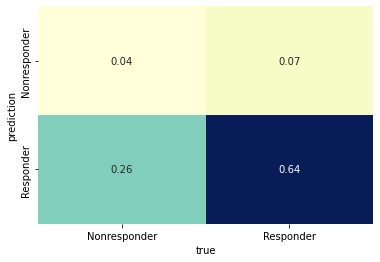

In [17]:
# rows: true, columns: pred
aml.confusion_matrix("xgb",plot=True, normalize=True)

In [18]:
# true
aml.saved_model['xgb'][0].value_counts()

Responder       60
Nonresponder    25
dtype: int64

In [19]:
# pred
aml.saved_model['xgb'][1].value_counts()

Responder       76
Nonresponder     9
dtype: int64

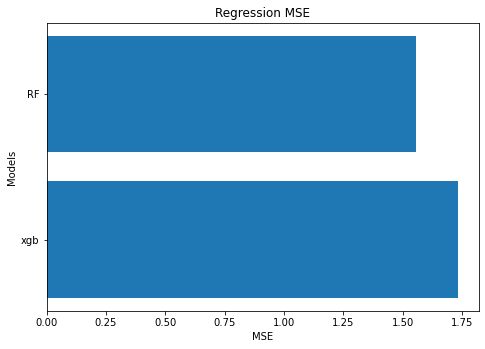

In [20]:
aml.plot_results('regression','MSE')

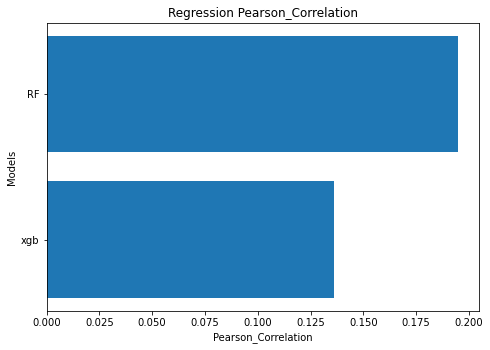

In [21]:
aml.plot_results('regression','Pearson_Correlation')

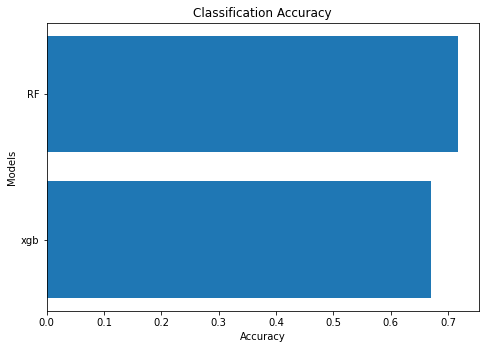

In [22]:
aml.plot_results('classification','Accuracy')

In [23]:
# aml.save_outputs(dataset,"../leaderboard")